In [ ]:
%pip install -q transformers diffusers accelerate

In [ ]:
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Useful function for later
'''
def load_image(url, size=None):
    response = requests.get(url,timeout=0.2)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img
'''
from PIL import Image

def load_image(file_path, size=None):
    """
    Load an image from a given file path and optionally resize it.

    Args:
        file_path (str): Path to the image file.
        size (tuple, optional): Desired size as (width, height). Default is None.

    Returns:
        PIL.Image.Image: The loaded and optionally resized image.
    """
    img = Image.open(file_path).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

## Loading an existing pipeline

In [ ]:
# Load a pipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Set up a DDIM scheduler
from diffusers import CMStochasticIterativeScheduler


In [ ]:
pipe.scheduler = CMStochasticIterativeScheduler.from_config(pipe.scheduler.config)

The config attributes {'clip_sample': False} were passed to CMStochasticIterativeScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [ ]:
pipe = pipe.to(device)

In [ ]:
# Check the text encoder
print("Text Encoder:", pipe.text_encoder)
print("Text Encoder Config:", pipe.text_encoder.config)

Text Encoder: CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerN

In [ ]:
print("Tokenizer:", pipe.tokenizer)
print("Tokenizer Details:", pipe.tokenizer.init_kwargs)

Tokenizer: CLIPTokenizer(name_or_path='/root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/f03de327dd89b501a01da37fc5240cf4fdba85a1/tokenizer', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
Tokenizer Details: {'errors': 'replace', 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True), 'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True), 'eos_token'

In [ ]:
# Load and replace the text encoder
from transformers import CLIPTextModel, CLIPTokenizer
new_text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
new_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
pipe.text_encoder = new_text_encoder
pipe.tokenizer = new_tokenizer

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

In [ ]:
# Check the text encoder
print("Text Encoder:", pipe.text_encoder)
print("Text Encoder Config:", pipe.text_encoder.config)

Text Encoder: CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerN

In [ ]:
print("Tokenizer:", pipe.tokenizer)
print("Tokenizer Details:", pipe.tokenizer.init_kwargs)

Tokenizer: CLIPTokenizer(name_or_path='openai/clip-vit-large-patch14', vocab_size=49408, model_max_length=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	49407: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
Tokenizer Details: {'errors': 'replace', 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True), 'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, spe

In [ ]:
import torch
from tqdm import tqdm
import torchvision.transforms as tfms

@torch.no_grad()
def invert(start_latents, prompt, pipe, guidance_scale=3.5, num_inference_steps=80,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device="cuda"):

    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Latents are now the specified start latents
    latents = start_latents.clone()

    # Set number of inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    for t in tqdm(pipe.scheduler.timesteps, total=num_inference_steps):
        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Use the scheduler's step function to update latents
        scheduler_output = pipe.scheduler.step(noise_pred, t, latents)
        latents = scheduler_output.prev_sample

        # Store intermediate latents
        intermediate_latents.append(latents)

    return torch.cat(intermediate_latents)

@torch.no_grad()
def sample(prompt, pipe, start_step=0, start_latents=None,
           guidance_scale=3.5, num_inference_steps=30,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device="cuda"):

    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Set number of inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):
        t = pipe.scheduler.timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Use the scheduler's step function to update latents
        scheduler_output = pipe.scheduler.step(noise_pred, t, latents)
        latents = scheduler_output.prev_sample

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

@torch.no_grad()
def edit(input_image, input_image_prompt, edit_prompt, pipe,
         num_steps=100, start_step=30, guidance_scale=3.5, device="cuda"):
    # Encode the input image to latents
    latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
    l = 0.18215 * latent.latent_dist.sample()

    # Invert the latents using the input image prompt
    inverted_latents = invert(l, input_image_prompt, pipe, num_inference_steps=num_steps)

    # Sample the edited image using the edit prompt
    final_im = sample(edit_prompt, pipe, start_latents=inverted_latents[-(start_step + 1)][None],
                      start_step=start_step, num_inference_steps=num_steps, guidance_scale=guidance_scale)[0]
    return final_im


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import json

# Specify the file path
file_path = '/content/drive/MyDrive/PIE-Bench_v1/mapping_file.json'

# Open and read the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Print the data or access specific keys
print(data)


{'000000000000': {'image_path': '0_random_140/000000000000.jpg', 'original_prompt': 'a slanted mountain bicycle on the road in front of a building', 'editing_prompt': 'a slanted [rusty] mountain bicycle on the road in front of a building', 'editing_instruction': 'Make the frame of the bike rusty', 'editing_type_id': '0', 'blended_word': 'bicycle bicycle', 'mask': [0, 513, 1023, 2, 1535, 2, 2047, 2, 2559, 2, 3071, 2, 3583, 2, 4095, 2, 4607, 2, 5119, 2, 5631, 2, 6143, 2, 6655, 2, 7167, 2, 7679, 2, 8191, 2, 8703, 2, 9215, 2, 9727, 2, 10239, 2, 10751, 2, 11263, 2, 11775, 2, 11950, 24, 12287, 2, 12460, 28, 12799, 2, 12971, 32, 13311, 2, 13482, 35, 13823, 2, 13993, 38, 14335, 2, 14505, 41, 14847, 2, 15016, 43, 15359, 2, 15528, 47, 15871, 2, 16040, 49, 16383, 2, 16552, 54, 16895, 2, 17064, 57, 17407, 2, 17575, 60, 17919, 2, 18086, 63, 18431, 2, 18598, 67, 18943, 2, 19109, 71, 19455, 2, 19621, 72, 19967, 2, 20132, 78, 20479, 2, 20643, 83, 20991, 2, 21155, 88, 21503, 2, 21667, 97, 22015, 2, 221

In [ ]:
data["911000000000"]

{'image_path': '9_change_style_80/1_artificial/1_animal/911000000000.jpg',
 'original_prompt': 'a cat and a bunny',
 'editing_prompt': '[a photo of] a cat and a bunny',
 'editing_instruction': 'change the style of the image to photo',
 'editing_type_id': '9',
 'blended_word': '',
 'mask': [0, 262144]}

In [ ]:
input_image = load_image('/content/drive/MyDrive/PIE-Bench_v1/annotation_images/1_change_object_80/1_artificial/1_animal/111000000000.jpg', size=(512, 512))


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:303: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 60/60 [00:26<00:00,  2.29it/s]
/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:589: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


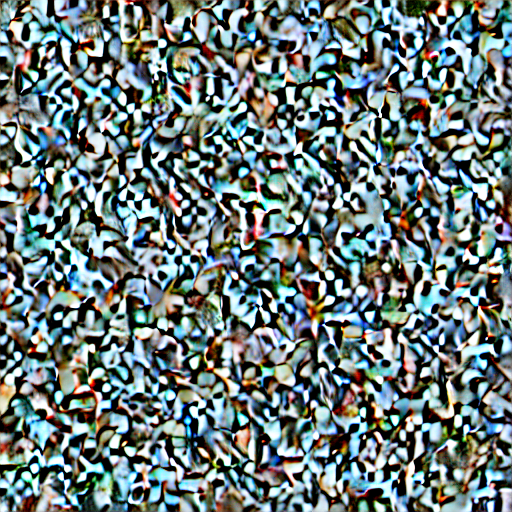

In [ ]:
edit(input_image, data["111000000000"]["original_prompt"], data["111000000000"]["editing_prompt"], pipe = pipe, num_steps=70, start_step=10, guidance_scale=0.5, device = device)